# Studying Wikipedia Page Protections
This notebook provides a tutorial for how to study [page protections](https://en.wikipedia.org/wiki/Wikipedia:Protection_policy) on Wikipedia either via the [Mediawiki dumps](https://www.mediawiki.org/wiki/Manual:Page_restrictions_table) or [API](https://www.mediawiki.org/w/api.php?action=help&modules=query%2Binfo). It has three stages:
* Accessing the Page Protection dumps
* Accessing the Page Protection API
* Example analysis of page protection data (both descriptive statistics and learning a predictive model)

## Importance of Page protection

What makes Wikipedia so great is its huge amount of open content about anything and everything in this world and its encouragement to improve contents by anyone around the globe. Eventhough it is self-correcting and protects certain contents, there are still important pages which aren't given any page protections. It might not look compromising but a great deal of attempts to vandalism can be reduced by protecting pages that are prone to corruption.

This notebook provides a model that could predict the protection type expected for a page based on its length(a measure of content depth) and no of watchers(a measure of interestingness)

## Accessing the Page Protection Dumps
This is an example of how to parse through [Mediawiki dumps](https://www.mediawiki.org/wiki/Manual:Page_restrictions_table) and determine [what sorts of edit protections](https://en.wikipedia.org/wiki/Wikipedia:Protection_policy#Overview_of_types_of_protection) are applied to a given Wikipedia article.

In [1]:
# TODO: add other libraries here as necessary
import gzip  # necessary for decompressing dump file into text format
import re  #necessary for extracting contents from page restrictions dump

In [2]:
# Every language on Wikipedia has its own page restrictions table
# you can find all the dbnames (e.g., enwiki) here: https://www.mediawiki.org/w/api.php?action=sitematrix
# for example, you could replace the LANGUAGE parameter of 'enwiki' with 'arwiki' to study Arabic Wikipedia
LANGUAGE = 'enwiki'
# e.g., enwiki -> en.wikipedia (this is necessary for the API section)
SITENAME = LANGUAGE.replace('wiki', '.wikipedia')
# directory on PAWS server that holds Wikimedia dumps
DUMP_DIR = "/public/dumps/public/{0}/latest/".format(LANGUAGE)
DUMP_FN = '{0}-latest-page_restrictions.sql.gz'.format(LANGUAGE)

In [3]:
# The dataset isn't huge -- 1.1 MB -- so should be quick to process in full
!ls -shH "{DUMP_DIR}{DUMP_FN}"

1.1M /public/dumps/public/enwiki/latest/enwiki-latest-page_restrictions.sql.gz


In [4]:
# Inspect the first 1000 characters of the page protections dump to see what it looks like
# As you can see from the CREATE TABLE statement, each datapoint has 7 fields (pr_page, pr_type, ... , pr_id)
# A description of the fields in the data can be found here:
#   https://www.mediawiki.org/wiki/Manual:Page_restrictions_table
# And the data that we want is on lines that start with INSERT INTO `page_restrictions` VALUES...
# The first datapoint (1086732,'edit','sysop',0,NULL,'infinity',1307) can be interpreted as:
#   1086732:    page ID 1086732 (en.wikipedia.org/wiki/?curid=1086732)
#   'edit':     has edit protections
#   'sysop':    that require sysop permissions (https://en.wikipedia.org/wiki/Wikipedia:User_access_levels#Administrator)
#   0:          does not cascade to other pages
#   NULL:       no user-specific restrictions
#   'infinity': restriction does not expire automatically
#   1307:       table primary key -- has no meaning by itself

!zcat "{DUMP_DIR}{DUMP_FN}" | head -46 | cut -c1-100

-- MySQL dump 10.16  Distrib 10.1.45-MariaDB, for debian-linux-gnu (x86_64)
--
-- Host: 10.64.48.13    Database: enwiki
-- ------------------------------------------------------
-- Server version	10.1.43-MariaDB

/*!40101 SET @OLD_CHARACTER_SET_CLIENT=@@CHARACTER_SET_CLIENT */;
/*!40101 SET @OLD_CHARACTER_SET_RESULTS=@@CHARACTER_SET_RESULTS */;
/*!40101 SET @OLD_COLLATION_CONNECTION=@@COLLATION_CONNECTION */;
/*!40101 SET NAMES utf8mb4 */;
/*!40103 SET @OLD_TIME_ZONE=@@TIME_ZONE */;
/*!40103 SET TIME_ZONE='+00:00' */;
/*!40014 SET @OLD_UNIQUE_CHECKS=@@UNIQUE_CHECKS, UNIQUE_CHECKS=0 */;
/*!40014 SET @OLD_FOREIGN_KEY_CHECKS=@@FOREIGN_KEY_CHECKS, FOREIGN_KEY_CHECKS=0 */;
/*!40101 SET @OLD_SQL_MODE=@@SQL_MODE, SQL_MODE='NO_AUTO_VALUE_ON_ZERO' */;
/*!40111 SET @OLD_SQL_NOTES=@@SQL_NOTES, SQL_NOTES=0 */;

--
-- Table structure for table `page_restrictions`
--

DROP TABLE IF EXISTS `page_restrictions`;
/*!40101 SET @saved_cs_client     = @@character_set_client */;
/*!40101 SET character_set_c

In [5]:
# TODO: Complete example that loops through all page restrictions in the dump file above and extracts data
# The Python gzip library will allow you to decompress the file for reading: https://docs.python.org/3/library/gzip.html#gzip.open
fin =gzip.open('/public/dumps/public/enwiki/latest/enwiki-latest-page_restrictions.sql.gz', mode='rt', compresslevel=9, encoding=None, errors=None, newline=None)
for line in fin:
    if line.find("INSERT INTO")!=-1: #To get the first "Insert into values" command from the file 
        contents=line
        break
data= contents[contents.find('('):contents.rfind(')')+1] #To extract datapoints from page restrictions table
dump_result = re.findall(r'\(.*?\)',data) # Here we assume that the entries doesn't contain paranthesis within themselves.

## Accessing the Page Protection APIs
The [Page Protection API](https://www.mediawiki.org/w/api.php?action=help&modules=query%2Binfo) can be a much simpler way to access data about page protections for a given article if you know what articles you are interested in and are interested in relatively few articles (e.g., hundreds or low thousands).

NOTE: the APIs are up-to-date while the Mediawiki dumps are always at least several days behind -- i.e. for specific snapshots in time -- so the data you get from the Mediawiki dumps might be different from the APIs if permissions have changed to a page's protections in the intervening days.

In [6]:
# TODO: add other libraries here as necessary
import mwapi # useful for accessing Wikimedia API
import random #useful for getting random pages

In [7]:
# TODO: Gather ten random page IDs from the data gathered from the Mediawiki dump to get data for from the API
ten_random_items = random.sample(dump_result, 10)
id_list=[] #To store list of page ids from random sample data
dump_data=[] #To store the page restriction data from the random sample data 
dump_protection_level=[]
for item in ten_random_items:
    item=item.strip('()')
    item=item.split(',')
    id_list.append(item[0])
    dump_dict={} # Each page restriction data is stored in a dictionary
    dump_dict['id']=item[0]
    dump_dict['type']=item[1]
    dump_dict['type']=dump_dict['type'].strip('\'')
    dump_dict['level']=item[2]
    dump_dict['level']=dump_dict['level'].strip('\'')
    dump_data.append(dump_dict) #adds each page restriction dictionary to a single list
    page_ids='|'.join(id_list) # joins all the page ids to pass it as a parameter to the page protection api
    
print(dump_data)

[{'id': '12430886', 'type': 'edit', 'level': 'sysop'}, {'id': '8677630', 'type': 'edit', 'level': 'sysop'}, {'id': '10297457', 'type': 'move', 'level': 'sysop'}, {'id': '16658266', 'type': 'move', 'level': 'autoconfirmed'}, {'id': '14605677', 'type': 'edit', 'level': 'sysop'}, {'id': '9344122', 'type': 'move', 'level': 'autoconfirmed'}, {'id': '11130882', 'type': 'move', 'level': 'sysop'}, {'id': '7750378', 'type': 'move', 'level': 'sysop'}, {'id': '10094794', 'type': 'move', 'level': 'sysop'}, {'id': '12156946', 'type': 'move', 'level': 'autoconfirmed'}]


In [8]:
# mwapi documentation: https://pypi.org/project/mwapi/
# user_agent helps identify the request if there's an issue and is best practice
tutorial_label = 'Page Protection API tutorial (mwapi)'
# NOTE: it is best practice to include a contact email in user agents
# generally this is private information though so do not change it to yours
# if you are working in the PAWS environment or adding to a Github repo
# for Outreachy, you can leave this as my (isaac's) email or switch it to your Mediawiki username
# e.g., Isaac (WMF) for https://www.mediawiki.org/wiki/User:Isaac_(WMF)
contact_email = 'isaac@wikimedia.org'
session = mwapi.Session('https://{0}.org'.format(SITENAME), user_agent='{0} -- {1}'.format(tutorial_label, contact_email))

# TODO: You'll have to add additional parameters here to query the pages you're interested in
# API endpoint: https://www.mediawiki.org/w/api.php?action=help&modules=query%2Binfo
# More details: https://www.mediawiki.org/wiki/API:Info

params = {  "action": "query",
            "format": "json",
            "pageids": page_ids,
            "prop": "info",
            "inprop": "protection"
            }

In [9]:
# TODO: make request to API for data
result = session.get(params)
keys=list(result['query']['pages'].keys())
print('API Results for',keys)

API Results for ['7750378', '8677630', '9344122', '10094794', '10297457', '11130882', '12156946', '12430886', '14605677', '16658266']


In [10]:
# TODO: examine API results and compare to data from Mediawiki dump to see if they are the same and explain any discrepancies
global i
i=0
con=list(result['query']['pages'].values()) #extracting data from the api result
api_data=[] #To store the page restriction data from the api
for key in keys:
    for item in dump_data:
        if key==item['id']:
                if(item['type']=='edit'):
                    api_dict={}
                    api_dict['id']=key
                    api_dict['type']='edit'
                    api_dict['level']=con[i]['protection'][0]['level']
                    api_data.append(api_dict)
                    i=i+1
                    if (item['level']!=api_dict['level']):
                        print('Mismatch at edit level page with id',format(item['id'])) #To check any mismatch for edit protections in dump_data and api_data
                    
                    
                else:
                    api_dict={}
                    api_dict['id']=key
                    api_dict['type']='move'
                    api_dict['level']=con[i]['protection'][1]['level']
                    api_data.append(api_dict)
                    i=i+1
                    if (item['level']!=api_dict['level']):
                        print('Mismatch at move page with id',format(item['id']))#To check any mismatch for move protections in dump_data and api_data
print(api_data)#Both dump data and api data seems to be the same
assert [i for i in api_data if i not in dump_data] == [] #To check if both api_data and dump_data is equal.

[{'id': '7750378', 'type': 'move', 'level': 'sysop'}, {'id': '8677630', 'type': 'edit', 'level': 'sysop'}, {'id': '9344122', 'type': 'move', 'level': 'autoconfirmed'}, {'id': '10094794', 'type': 'move', 'level': 'sysop'}, {'id': '10297457', 'type': 'move', 'level': 'sysop'}, {'id': '11130882', 'type': 'move', 'level': 'sysop'}, {'id': '12156946', 'type': 'move', 'level': 'autoconfirmed'}, {'id': '12430886', 'type': 'edit', 'level': 'sysop'}, {'id': '14605677', 'type': 'edit', 'level': 'sysop'}, {'id': '16658266', 'type': 'move', 'level': 'autoconfirmed'}]


## Example Analyses of Page Protection Data
Here we show some examples of things we can do with the data that we gathered about the protections for various Wikipedia articles. You'll want to come up with some questions to ask of the data as well. For this, you might need to gather additional data such as:
* The [page table](https://www.mediawiki.org/wiki/Manual:Page_table), which, for example, can be found in the `DUMP_DIR` under the name `{LANGUAGE}-latest-page.sql.gz`
* Selecting a sample of, for example, 100 articles and getting additional information about them from other [API endpoints](https://www.mediawiki.org/wiki/API:Properties).

In [11]:
# TODO: add any imports of data analysis / visualization libraries here as necessary
import pandas as pd #Allows use of dataframes
import seaborn as sns #For visualization
import matplotlib.pyplot as plt #To plot graphs
from scipy.stats import pearsonr, spearmanr #To find correlations among variables

In [12]:
#Get the list of the top 500 pages
content=[]
page_limit=500
params = {
	"action": "query",
	"format": "json",
	"list": "mostviewed",
	"pvimmetric": "pageviews",
	"pvimlimit": page_limit
}
result = session.get(params)
d=result['query']['mostviewed']

In [13]:
#Get page protection data based on the titles collected from most viewed pages
split_list=list(range(50,page_limit+1,50)) #To split the titles into a group of 50 each as we can only get protection data of 50 pages at a time
res = [d[i : j] for i, j in zip([0] + 
          split_list, split_list + [None])]
for i in range(int(page_limit/50)):
    par = {
	"action": "query",
	"format": "json",
	"prop": "info",
	"titles": '|'.join([item['title'] for item in res[i]]),
	"inprop": "protection|watchers", #get protection data along with the no of watchers for each page title
   
    }
    result = session.get(par)
    li=list(result['query']['pages'].values())
    content.extend(li)
for i in content:
    if 'protection' in i:
        if len(i['protection'])!=0 and len(i['protection'])!=2:
            i.clear()
for i in content:
    if 'protection' in i:
        if len(i['protection'])>2: #remove pages with cascaded protections
            i.clear()
        if i['protection']==[]: #If both edit or move protection is not specified, then the page is labelled to be not protected
            i['edit_protection_level']='notprotected'
            i['move_protection_level']='notprotected'
            i['protection_type']= 'noprotection'
        else:
            if i['protection'][0]!=[] and i['protection'][0]['type']=='edit':
                #creating columns for protection levels
                i['edit_protection_level']=i['protection'][0]['level']
                i['move_protection_level']=i['protection'][1]['level']
            else:
                i['move_protection_level']=i['protection'][0]['level'] #If edit protection is not specified, then the first entry will be of move protection
        
            if i['edit_protection_level']=='sysop' and i['move_protection_level']=='sysop': #Only admins can edit or move fully protected pages.
                i['protection_type']= 'fullprotection'
            else:
                i['protection_type']= 'semiprotection' # All the protected pages other than fully protected ones are taken to be semi protected.
            
df = pd.DataFrame(content,columns=['title','length','watchers','edit_protection_level','move_protection_level','protection_type'])
df.head()

,title,length,watchers,edit_protection_level,move_protection_level,protection_type
0,Special:Search,NaN,NaN,NaN,NaN,NaN
1,2012 United States presidential election,138606.0,470.0,notprotected,notprotected,noprotection
2,2016 United States presidential election,380837.0,813.0,autoconfirmed,autoconfirmed,semiprotection
3,2020 United States presidential election,255027.0,542.0,extendedconfirmed,extendedconfirmed,semiprotection
4,Amy Coney Barrett,125597.0,237.0,autoconfirmed,sysop,semiprotection


### Descriptive statistics
TODO: give an overview of basic details about page protections and any conclusions you reach based on the analyses you do below

In [14]:
# TODO: do basic analyses here to understand the data
edit_count=df['edit_protection_level'].value_counts()
print(edit_count) # Count of pages with different levels in edit protection
move_count=df['move_protection_level'].value_counts()
print(move_count) # Count of pages with different levels in edit protection

notprotected         271
autoconfirmed        166
extendedconfirmed     12
sysop                  1
Name: edit_protection_level, dtype: int64
notprotected         271
sysop                 99
autoconfirmed         73
extendedconfirmed      7
Name: move_protection_level, dtype: int64


Around half of the pages are unprotected. Out of the protected pages, most edit protections are autoconfirmed while move protections are mostly sysop. This suggests that most of the protected pages are open to edit if the user is consistent in editing Wikipedia pages while its hard to move a lot of protected pages unless you are an admin.So a new Wikipedia contributor might not be able to edit most of the protected pages.

## Relationship between protection levels and watchers

Conclusions
If we try to analyse the variation in the no of "watchers" (a rough proxy of the interestingness of the page) and the level of protection( a rough proxy about how much sensitive the topic is about), we find that 
* fully protected pages have the most no of watchers whereas unprotected pages have the least no of watchers.
* Wikipedians are more interested to watch pages with sensitive contents.
* It can also mean that pages without much watchers are not protected well but this doesn't mean those contents wouldn't get corrupted


<AxesSubplot:xlabel='edit_protection_level', ylabel='watchers'>

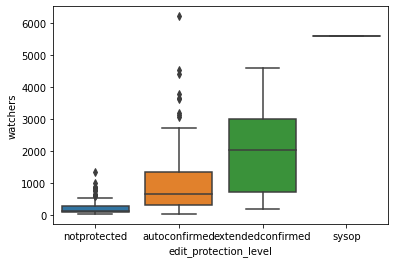

In [15]:
sns.boxplot(x='edit_protection_level',y='watchers',data=df)

We see that the extended confirmed pages have highest no of average watchers(if the only sysop page is excluded) This suggests that sensitive contents seems to be a bit more interesting to watch. 

<AxesSubplot:xlabel='move_protection_level', ylabel='watchers'>

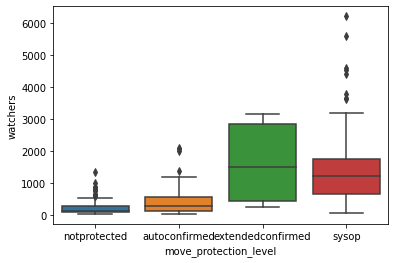

In [16]:
sns.boxplot(x='move_protection_level',y='watchers',data=df)

Even in the case of move protection, unprotected pages have the least no of watchers, which means lesser sensitive pages are more likely to get fewer watchers

In [17]:
df_test=df[['edit_protection_level','move_protection_level','watchers']]
df_grp= df_test.groupby(['edit_protection_level','move_protection_level'],as_index=False).mean()
df_grp

,edit_protection_level,move_protection_level,watchers
0,autoconfirmed,autoconfirmed,450.287671
1,autoconfirmed,extendedconfirmed,339.000000
2,autoconfirmed,sysop,1396.516484
3,extendedconfirmed,extendedconfirmed,2279.000000
4,extendedconfirmed,sysop,1833.142857
5,notprotected,notprotected,213.609626
6,sysop,sysop,5587.000000


It confirms the above observation on the correspondance between protection levels and no of watchers. A fully protected page (which might contain the most sensitive information) is the most watched while pages without any protections have the least popularity. So no of watchers in a particular page can be potentially used as a feature to predict its protection type.

## Relationship between length and watchers

Conclusions
We see a clear positive correlation between length of a page (our proxy for content size/depth) and # of watchers (our proxy for interestingness/popularity) -- i.e. Wikipedia pages with larger contents tend to attract more no of Wikipedians to watch that page.

Correlation between length and watchers
Pearson (linear) correlation between the length of the page and # of its watchers: 0.5904 (p=0.0000)
Spearman (rank) correlation between the length of the page and # of its watchers: 0.7164 (p=0.0000)


(0.0, 6526.109491378571)

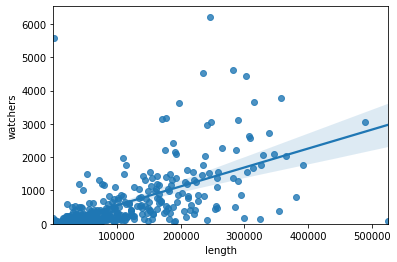

In [18]:
df.dropna(axis=0,inplace=True) #deleting rows with null values
print("Correlation between length and watchers")
pcorr_coef, pval = pearsonr(df['length'], df['watchers'])
print("Pearson (linear) correlation between the length of the page and # of its watchers: {0:.4f} (p={1:0.4f})".format(pcorr_coef, pval))

scorr_coef, pval = spearmanr(df['length'], df['watchers'])
print("Spearman (rank) correlation between the length of the page and # of its watchers: {0:.4f} (p={1:0.4f})".format(scorr_coef, pval))
sns.regplot(x='length',y='watchers',data=df)
plt.ylim(0,)

Most of the pages have less than 1000 watchers.There seems to be a positive correlation between the no of watchers and length of the page which suggests that the users are more interested in topics with a lot of content. That inturn qualifies length to be a potential feature to predict the protection type of a page.

<AxesSubplot:xlabel='length', ylabel='watchers'>

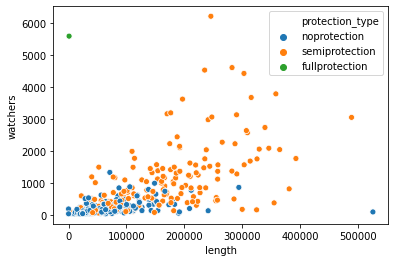

In [19]:
sns.scatterplot(x='length',y='watchers',hue='protection_type',data=df)

Semi protected pages tend to be long and have more no of watchers while unprotected pages have lesser watchers and length which allows us to classify them distinctively.

### Predictive Model
TODO: Train and evaluate a predictive model on the data you gathered for the above descriptive statistics. Describe what you learned from the model or how it would be useful.
#### This model predicts the protection type of a given page based on its length and no of watchers

In [20]:
# imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import svm,tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [21]:
# TODO: preprocess data
df.dropna(axis=0,inplace=True) #deleting rows with null values
#normalizing numerical variables using min-max method
df['watchers']=(df['watchers']-df['watchers'].min())/(df['watchers'].max()-df['watchers'].min())
df['length']=(df['length']-df['length'].min())/(df['length'].max()-df['length'].min())
#Convert categorical variables into numerical variables
le=LabelEncoder()
df['protection_type']=le.fit_transform(df['protection_type'])
df.head()

,title,length,watchers,edit_protection_level,move_protection_level,protection_type
1,2012 United States presidential election,0.263774,0.071209,notprotected,notprotected,1
2,2016 United States presidential election,0.724869,0.126720,autoconfirmed,autoconfirmed,2
3,2020 United States presidential election,0.485386,0.082861,extendedconfirmed,extendedconfirmed,2
4,Amy Coney Barrett,0.239011,0.033501,autoconfirmed,sysop,2
5,Anya Taylor-Joy,0.076090,0.011491,notprotected,notprotected,1


In [22]:
#Splitting Dataset
X = df[['length','watchers']]
y = df[['protection_type']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("X_train ({0}):\n{1}".format(len(X_train), X_train.head()))
print("\ny_train ({0}):\n{1}".format(len(y_train), y_train.head()))
print("\nX_test ({0}):\n{1}".format(len(X_test), X_test.head()))
print("\ny_test ({0}):\n{1}".format(len(y_test), y_test.head()))

X_train (292):
       length  watchers
420  0.082101  0.030426
201  0.159906  0.014242
130  0.167667  0.034795
383  0.101319  0.026380
143  0.194377  0.047257

y_train (292):
     protection_type
420                1
201                1
130                1
383                1
143                1

X_test (73):
       length  watchers
250  0.029432  0.007445
79   0.076177  0.187409
70   0.374457  0.580838
414  0.225104  0.091277
274  0.037970  0.021525

y_test (73):
     protection_type
250                2
79                 2
70                 2
414                1
274                1


In [23]:
# TODO: train model
#Base Model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(X_train, y_train.values.ravel()) #Train
predictions = clf.predict(X_test) #Predict
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions)) #Evaluate

              precision    recall  f1-score   support

           1       0.83      0.87      0.85        46
           2       0.76      0.70      0.73        27

    accuracy                           0.81        73
   macro avg       0.80      0.79      0.79        73
weighted avg       0.81      0.81      0.81        73



The base model classifies the pages with an accuracy of 0.81 which is pretty good considering the few no of features we chose.

In [24]:
# Choosing the best classification model
classifiers=[] #To store different classifiers
model1 = svm.SVC()
classifiers.append(model1)
model2 = tree.DecisionTreeClassifier()
classifiers.append(model2)
model3 = RandomForestClassifier()
classifiers.append(model3)
model4 = KNeighborsClassifier()
classifiers.append(model4)
for clf in classifiers: # Using different classifiers to predict the target variable
    clf.fit(X_train, y_train.values.ravel()) #Train
    y_pred= clf.predict(X_test) #Predict
    acc = accuracy_score(y_test, y_pred) #Evaluate
    print("Accuracy of %s is %s"%(clf, acc))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix of %s is \n %s"%(clf, cm))

Accuracy of SVC() is 0.821917808219178
Confusion Matrix of SVC() is 
 [[41  5]
 [ 8 19]]
Accuracy of DecisionTreeClassifier() is 0.684931506849315
Confusion Matrix of DecisionTreeClassifier() is 
 [[31 15]
 [ 8 19]]
Accuracy of RandomForestClassifier() is 0.7123287671232876
Confusion Matrix of RandomForestClassifier() is 
 [[34 12]
 [ 9 18]]
Accuracy of KNeighborsClassifier() is 0.7397260273972602
Confusion Matrix of KNeighborsClassifier() is 
 [[35 11]
 [ 8 19]]


It’s clearly visible from the output that the Support Vector Machine model outperperformed all the other classification models for this problem and turned out to be the best algorithm for the prediction of the protection type in our case.

### Future Analyses
TODO: Describe any additional analyses you can think of that would be interesting (and why) -- even if you are not sure how to do them.

* Classify pages based on their contents using NLP/text analysis techniques and predict its advised protection type because the type/topic of the pages also affect how much protection it needs.
* To analyse the reasons for protection and find how it influences the interestingness/popularity of pages
* Find more relevant features to add to this model for predicting protection type- like no of images, links, edits per month, categories etc 
* Get a larger dataset to train the model